Paquetes

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.io as pio
import kaleido
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor,HuberRegressor, LinearRegression,Lasso,Ridge, LassoCV, RidgeCV,GammaRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import normalize,StandardScaler,PolynomialFeatures
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_boston

Funciones

In [2]:
def seleccion_caracteristicas(func,n,X,y):
    if isinstance(n,list)==False:
        selector = RFE(func, n_features_to_select=n, step=1)
        selector = selector.fit(X, y)
        X_selected = X[:,selector.support_]
        score = []
        for i in range(0,100):
            X_train,X_val,y_train,y_val = train_test_split(X_selected, y,train_size=0.8,random_state=i)
            reg = func.fit(X_train, y_train)
            score.append(reg.score(X_val,y_val))
        return score
    else:
        score = []
        sample = []
        features = []
        for i in range(0,100):
            X_train,X_val,y_train,y_val = train_test_split(X, y,train_size=0.8,random_state=i)
            for j in n:
                sample.append(i)
                selector = RFE(func, n_features_to_select=j, step=1)
                selector = selector.fit(X, y)
                reg = func.fit(X_train[:,selector.support_], y_train)
                score.append(reg.score(X_val[:,selector.support_],y_val))
                features.append(j)
        return sample,features,score

Cargo el dataset.

In [3]:
boston = load_boston()

Empiezo a armar el data frame

In [4]:
data_boston = pd.DataFrame(boston.data)

In [5]:
data_boston.columns =  list(boston.feature_names)

In [6]:
data_boston["Price"] = boston.target

In [7]:
data_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Descripción de las variables:

In [8]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Exploración

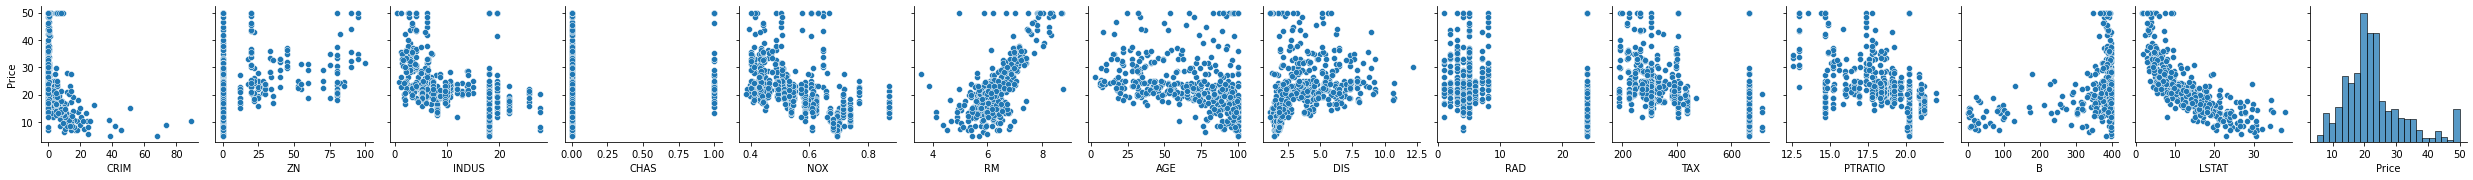

In [9]:
sns.pairplot(data_boston,y_vars="Price")
plt.show()

<AxesSubplot:>

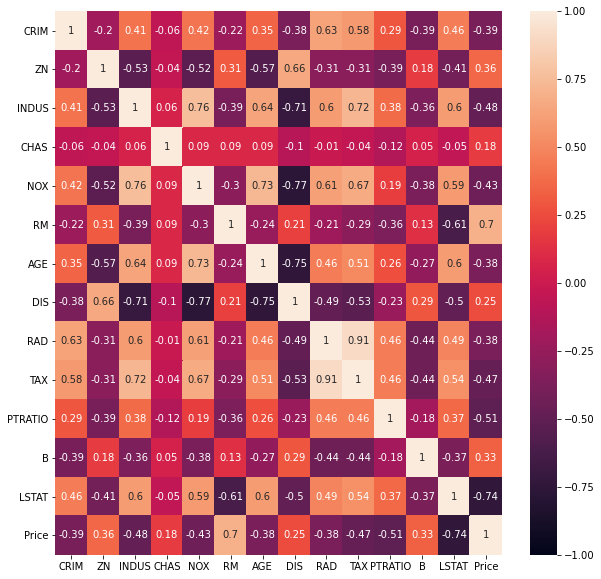

In [10]:
fig, ax = plt.subplots(figsize=(10,10))      
sns.heatmap(round(data_boston.corr(),2),annot=True, vmin=-1, vmax=1)

In [11]:
correlations = round(data_boston.corr(),2)

In [12]:
correlations["Price"].abs().sort_values(ascending = False)

Price      1.00
LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
AGE        0.38
RAD        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: Price, dtype: float64

En principio, las variables con mayor correlación con el precio medio son: LSTAT, RM, PTRATIO, INDUS, TAX y NOX

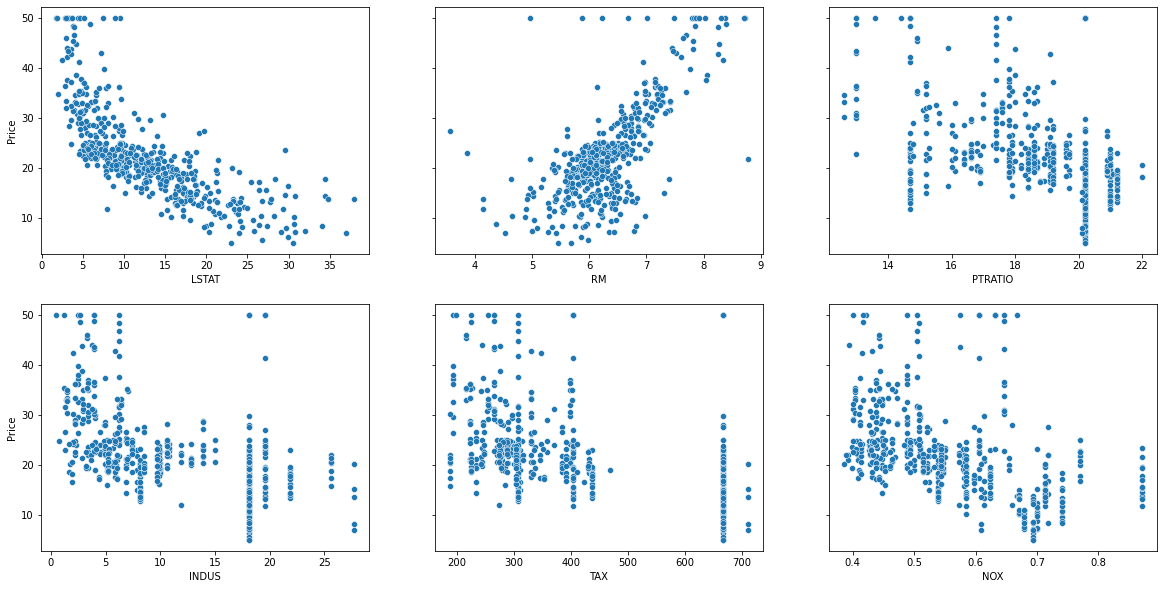

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
sns.scatterplot(ax=axes[0,0],x=data_boston.LSTAT,y=data_boston.Price)
sns.scatterplot(ax=axes[0,1], x=data_boston.RM,y=data_boston.Price)
sns.scatterplot(ax=axes[0,2], x=data_boston.PTRATIO,y=data_boston.Price)

sns.scatterplot(ax=axes[1,0],x=data_boston.INDUS,y=data_boston.Price)
sns.scatterplot(ax=axes[1,1], x=data_boston.TAX,y=data_boston.Price)
sns.scatterplot(ax=axes[1,2], x=data_boston.NOX,y=data_boston.Price)

plt.show()

Se puede observar que cuanto menor es el precio medio de la casa en la ciudad, mayor es el porcentaje de pobres. Esto no quiere decir que las viviendas salgan más baratas porque hay pobres. La gente de bajos ingresos busca precios de vivienda más reducidos para vivir y por ello se da esa correlación. Esos precios bajos a su vez, tienen lugar porque están asociados a otras características de la vivienda o de la ciudad. Esto puede conducir a casos de multicolinealidad. Por ejemplo, la variable LSTAT está muy correlacionada con la cantidad de habitaciones y con la contaminación. A menor cantidad de habitaciones y a mayor contaminación, se reduce el precio de la casa.



### Modelos lineales

Un primer modelo sencillo, con la variables de mayor correlación. Hay que tener en cuenta los comentarios señalados anteriormente.

In [14]:
y = np.array(data_boston["Price"])

In [15]:
X = np.array(data_boston.loc[:,["LSTAT","RM","PTRATIO","NOX","TAX","INDUS"]])

In [16]:
X_scale = StandardScaler().fit_transform(X)

In [17]:
lm1 = LinearRegression()

In [18]:
lm1.fit(X_scale,y)

LinearRegression()

In [19]:
lm1.coef_

array([-3.89469824,  3.26810054, -1.9764135 , -0.39395547, -0.48846049,
        0.59754458])

In [20]:
lm1.score(X_scale,y)

0.6810217497396303

In [21]:
residuos = data_boston.copy()
residuos["Prediccion 1"] = lm1.predict(X_scale)
residuos["Residuos 1"] = residuos["Prediccion 1"] - residuos["Price"]

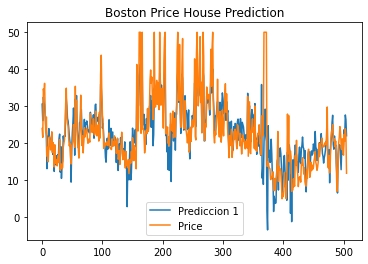

In [22]:
fig = residuos.loc[:,["Prediccion 1","Price"]].plot()
plt.title("Boston Price House Prediction")
plt.show()

<AxesSubplot:xlabel='Residuos 1', ylabel='Price'>

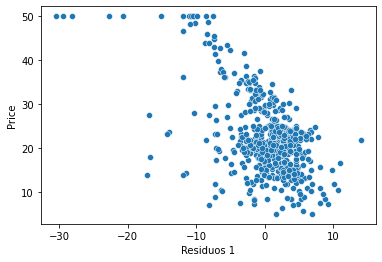

In [23]:
sns.scatterplot(data = residuos,x="Residuos 1",y="Price")

In [24]:
round(residuos.corr(),2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price,Prediccion 1,Residuos 1
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39,-0.43,0.06
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36,0.45,0.02
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48,-0.59,-0.00
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18,0.10,-0.16
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43,-0.52,-0.00
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70,0.84,0.00
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38,-0.50,-0.06
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25,0.42,0.18
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38,-0.51,-0.06
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47,-0.57,-0.00


Los residuos se encuentran correlacionados con los precios. El modelo se puede seguir mejorando

Se puede crear un modelo que agregue más características e implementar un algoritmo de selección automática de características para evitar el overfitting del modelo. La función de más arriba implementa dicho algoritmo

In [25]:
X = data_boston.loc[:,['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']]
X_scale = StandardScaler().fit_transform(X)

In [26]:
lm = LinearRegression()
scores = []
features = []
sample = []
for i in range(1,X_scale.shape[1]):
    score = seleccion_caracteristicas(lm,i,X_scale,y)
    scores += score
    features += list(np.repeat(i,len(score)))
    sample += list(range(0,100))

In [27]:
Lineal_Features = pd.DataFrame({"Features":features,"Scores":scores,"Sample":sample})

In [28]:
Lineal_Features.groupby("Features").mean().sort_values("Scores",ascending=False)[:4]

,Scores,Sample
Features,,
11,0.711159,49.5
10,0.710920,49.5
12,0.710254,49.5
9,0.705036,49.5


In [29]:
Lineal_Features.groupby("Features").median().sort_values("Scores",ascending=False)[:4]

,Scores,Sample
Features,,
10,0.715984,49.5
11,0.715162,49.5
12,0.714905,49.5
9,0.710133,49.5


In [30]:
Lineal_Features.groupby("Features").min().sort_values("Scores",ascending=False)[:4]

,Scores,Sample
Features,,
9,0.553135,0
10,0.551880,0
8,0.537759,0
12,0.512206,0


<AxesSubplot:xlabel='Sample', ylabel='Scores'>

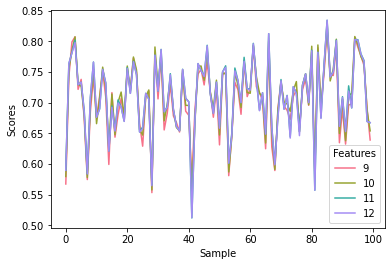

In [31]:
color = sns.color_palette("husl", 4)
sns.lineplot(data=Lineal_Features.loc[Lineal_Features.Features.isin([11,12,9,10]),:],x="Sample",y="Scores",hue="Features",palette= color)

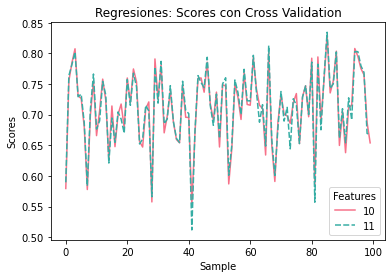

In [32]:
color = sns.color_palette("husl", 2)
fig = sns.lineplot(data=Lineal_Features.loc[Lineal_Features.Features.isin([11,10]),:],x="Sample",y="Scores",hue="Features",style="Features",palette= color)
fig.set_title("Regresiones: Scores con Cross Validation")
plt.show()

La que tiene 10 características es el mejor modelo. Es el segundo en media, pero es el primero en mediana y tiene el máximo score mínimo.

In [33]:
selector = RFE(lm, n_features_to_select=10, step=1)
selector = selector.fit(X_scale, y)
selector_lm = selector.support_

In [34]:
X_scale[:,selector.support_]

array([[-0.41978194,  0.28482986, -0.14421743, ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.74026221, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.74026221, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.15812412, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.15812412, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236,  0.15812412, ...,  1.17646583,
         0.44105193, -0.66905833]])

In [35]:
X.iloc[:,selector.support_]

,CRIM,ZN,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,0.538,6.575,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,0.469,6.421,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,0.469,7.185,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,0.458,6.998,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,0.458,7.147,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,0.573,6.593,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,0.573,6.120,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,0.573,6.976,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,0.573,6.794,2.3889,1.0,273.0,21.0,393.45,6.48


La que no se encuentra presente es INDUS

In [36]:
lm2 = lm.fit(X_scale[:,selector.support_],y)

In [37]:
lm2.score(X_scale[:,selector.support_],y)

0.7352631473231817

In [38]:
residuos["Prediccion 2"] = lm2.predict(X_scale[:,selector.support_])
residuos["Residuos 2"] = residuos["Prediccion 2"] - residuos["Price"]

<AxesSubplot:>

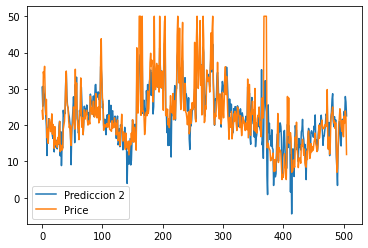

In [39]:
residuos.loc[:,["Prediccion 2","Price"]].plot()


<AxesSubplot:xlabel='Price', ylabel='Residuos 2'>

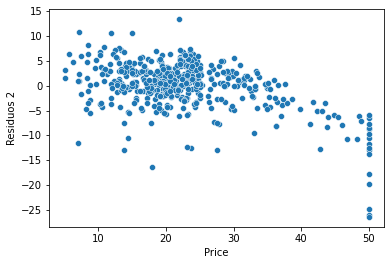

In [72]:
sns.scatterplot(data = residuos,y="Residuos 2",x="Price")

In [82]:
round(residuos.loc[:,["Residuos 2","Price"]].corr(),2)

,Residuos 2,Price
Residuos 2,1.00,-0.51
Price,-0.51,1.00


Los residuos siguen correlacionados con los precios.

### Regresiones polinómicas

#### Segundo grado

Haremos lo mismo pero para un modelo que permita interacciones de segundo grado entre las variables

In [40]:
poly = PolynomialFeatures(degree=2)

In [41]:
X_scale2 = poly.fit_transform(X_scale)

In [42]:
lm = LinearRegression()
scores = []
features = []
sample = []
for i in range(1,X_scale2.shape[1]):
    score = seleccion_caracteristicas(lm,i,X_scale2,y)
    scores += score
    features += list(np.repeat(i,len(score)))
    sample += list(range(0,100))

In [43]:
Pol_Features = pd.DataFrame({"Features":features,"Scores":scores,"Sample":sample})

In [44]:
Pol_Features.groupby("Features").mean().sort_values("Scores",ascending=False)[:4]

,Scores,Sample
Features,,
69,0.878806,49.5
67,0.878486,49.5
68,0.878238,49.5
70,0.877816,49.5


In [45]:
Pol_Features.groupby("Features").median().sort_values("Scores",ascending=False)[:8]

,Scores,Sample
Features,,
68,0.884632,49.5
67,0.884261,49.5
69,0.884220,49.5
70,0.883749,49.5
73,0.883564,49.5
72,0.883240,49.5
74,0.882885,49.5
75,0.882772,49.5


In [46]:
Pol_Features.groupby("Features").min().sort_values("Scores",ascending=False)[:4]

,Scores,Sample
Features,,
69,0.767479,0
70,0.766628,0
71,0.766431,0
68,0.765737,0


El mejor modelo es el de 69 características (Me cuesta mucho creerlo, habrá que validarlo bastante). Tiene un mayor mínimo y una mayor media y es el tercero en mediana.

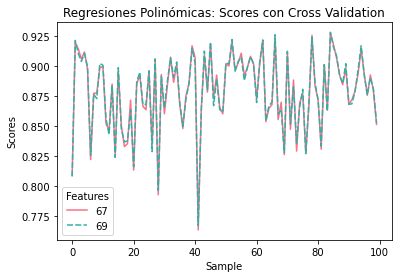

In [47]:
color = sns.color_palette("husl", 2)
fig = sns.lineplot(data=Pol_Features.loc[Pol_Features.Features.isin([67,69]),:],x="Sample",y="Scores",hue="Features",style="Features",palette= color)
fig.set_title("Regresiones Polinómicas: Scores con Cross Validation")
plt.show()

In [48]:
selector = RFE(lm, n_features_to_select=69, step=1)
selector = selector.fit(X_scale2, y)
selector_pol = selector.support_

In [49]:
X_scale2[:,selector_pol]

array([[-0.41978194,  0.28482986, -1.2879095 , ..., -0.29400884,
         0.71697866,  1.15683427],
       [-0.41733926, -0.48772236, -0.59338101, ..., -0.43546358,
         0.48619991,  0.24249653],
       [-0.41734159, -0.48772236, -0.59338101, ..., -0.39140406,
         1.1934122 ,  1.46102192],
       ...,
       [-0.41344658, -0.48772236,  0.11573841, ..., -0.35425808,
         0.78959536,  0.9663826 ],
       [-0.40776407, -0.48772236,  0.11573841, ..., -0.32387496,
         0.69502041,  0.74874691],
       [-0.41500016, -0.48772236,  0.11573841, ..., -0.35425808,
         0.53739549,  0.44763905]])

In [50]:
lm_pol = lm.fit(X_scale2[:,selector_pol],y)

In [51]:
lm_pol.score(X_scale2[:,selector_pol],y)

0.9256119056799619

In [52]:
residuos["Prediccion 3"] = lm_pol.predict(X_scale2[:,selector_pol])
residuos["Residuos 3"] = residuos["Prediccion 3"] - residuos["Price"]

<AxesSubplot:>

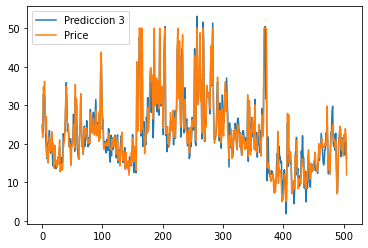

In [53]:
residuos.loc[:,["Prediccion 3","Price"]].plot()

<AxesSubplot:xlabel='Price', ylabel='Residuos 3'>

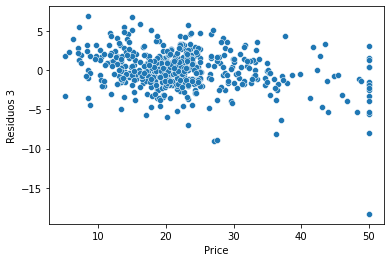

In [71]:
sns.scatterplot(data = residuos,y="Residuos 3",x="Price")

Los residuos están mucho mejor que en el caso del modelo lineal.

#### Tercer grado

Este modelo no tiene buen desempeño y es ineficiente en el tiempo.

In [54]:
# poly3 = PolynomialFeatures(degree=3)
# X_scale3 = poly3.fit_transform(X_scale)
# lm = LinearRegression()
# scores = []
# features = []
# sample = []
# for i in range(1,X_scale3.shape[1]):
#     score = seleccion_caracteristicas(lm,i,X_scale3,y)
#     scores += score
#     features += list(np.repeat(i,len(score)))
#     sample += list(range(0,100))
# Pol3_Features = pd.DataFrame({"Features":features,"Scores":scores,"Sample":sample})
# Pol3_Features.groupby("Features").mean().sort_values("Scores",ascending=False)[:4]
# Pol3_Features.groupby("Features").median().sort_values("Scores",ascending=False)[:4]
# Pol3_Features.groupby("Features").min().sort_values("Scores",ascending=False)[:5]
# color = sns.color_palette("husl", 4)
# fig = sns.lineplot(data=Pol3_Features.loc[Pol3_Features.Features.isin([67,68,71,72]),:],x="Sample",y="Scores",hue="Features",style="Features",palette= color)
# fig.set_title("Regresiones Polinómicas: Scores con Cross Validation")
# plt.show()
# color = sns.color_palette("husl", 2)
# fig = sns.lineplot(data=Pol3_Features.loc[Pol3_Features.Features.isin([71,67]),:],x="Sample",y="Scores",hue="Features",style="Features",palette= color)
# fig.set_title("Regresiones Polinómicas: Scores con Cross Validation")
# plt.show()
# selector = RFE(lm, n_features_to_select=71, step=1)
# selector = selector.fit(X_scale3, y)
# selector_pol3 = selector.support_
# X_scale3.shape

### Competencia entre mejor modelo lineal y el polinómico

In [55]:
X_scale[:,selector_lm]

array([[-0.41978194,  0.28482986, -0.14421743, ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.74026221, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.74026221, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.15812412, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.15812412, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236,  0.15812412, ...,  1.17646583,
         0.44105193, -0.66905833]])

Hay que scalar el selector de lm para que sea igual al del polinomio para poder aplicar el spliteo sobre X_scale2

In [56]:
selector_lm_ = np.concatenate((np.array([False]),selector_lm,np.repeat([False],len(selector_pol)-1-len(selector_lm))), axis=0)

In [57]:
len(selector_lm_) ==len(selector_pol)

True

In [67]:
score_lm = []
score_pol = []
sample = []
for i in range(0,100):
    sample.append(i)
    X_train,X_val,y_train,y_val = train_test_split(X_scale2,y,train_size=0.8)
    lm.fit(X_train[:,selector_lm_],y_train)
    score_lm.append(lm.score(X_val[:,selector_lm_],y_val))
    lm_pol.fit(X_train[:,selector_pol],y_train)
    score_pol.append(lm_pol.score(X_val[:,selector_pol],y_val))


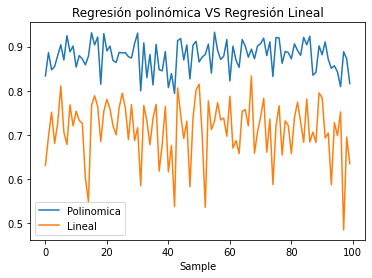

In [68]:
fig = pd.DataFrame({"Polinomica":score_pol,"Lineal":score_lm,"Sample":sample}).set_index("Sample").plot()
fig.set_title("Regresión polinómica VS Regresión Lineal")
plt.show()

In [69]:
pd.DataFrame({"Polinomica":score_pol,"Lineal":score_lm}).describe()

,Polinomica,Lineal
count,100.000000,100.000000
mean,0.878824,0.712336
std,0.033093,0.066260
min,0.794040,0.484884
25%,0.858152,0.683227
50%,0.881726,0.723732
75%,0.904106,0.761447
max,0.932539,0.833386


In [83]:
round(residuos.loc[:,["Residuos 1","Residuos 2","Residuos 3","Price"]].corr(),2)

,Residuos 1,Residuos 2,Residuos 3,Price
Residuos 1,1.00,0.91,0.48,-0.56
Residuos 2,0.91,1.00,0.53,-0.51
Residuos 3,0.48,0.53,1.00,-0.27
Price,-0.56,-0.51,-0.27,1.00


El modelo de regresión polinomial es mejor que el lineal. Tine mayor media, mediana, mínimo, máximo y menor desviación estándar que el modelo lineal de primer grado. Además, los residuos están menos correlacionados con la variable dependiente.